In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from torch.optim import lr_scheduler
import time


* Since there is no need to split the dataset into train and test set
* First, combine train & test set

In [2]:
PATH = './train/train_df.csv'
train_df = pd.read_csv(PATH) 
PATH = './test/test_df.csv'
test_df = pd.read_csv(PATH)

In [3]:
full_df = np.vstack([train_df,test_df])
full_df = pd.DataFrame(full_df,columns=train_df.columns)
full_df

,stars,text,label
0,5,My go to place in East Nashville!Three suggest...,2
1,2,Skip it! Not worth the $27.50. The cruise itse...,0
2,2,We came here for lunch with a coupon. In order...,0
3,5,I attended PMA's Risk Management Professional ...,2
4,4,"Love the food at El Tumi, but it is truly fami...",2
...,...,...,...
19995,5,"Perfect New Orleans experience! Live music, gr...",2
19996,5,Fantastic Detroit family has joined the revolu...,2
19997,2,I saw Big Data when they came to town at the K...,0
19998,5,I have always dreaded going to the hair salon....,2


* Then performing the text data vectorization
* Choose TF-IDF since 
    * It takes into account the frequency of the word in the document and its importance in the whole collection.TfidfVectorizer is a common TF-IDF vectorizer used in scikit-learn.
    * Reducing the impact of common words: TF-IDF can reduce the weight of frequently occurring but less informative words, and focus on more discriminative words.
    * Applicability: Suitable for most text categorization problems, especially when focusing on important words in a document.

In [4]:
text_data, y = full_df['text'], full_df['label']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text_data).toarray()

In [5]:
X.shape

(20000, 34097)

* I find that our matrix is a sparse matrix obtained by tf-idf text vectorization, for sparse matrix, PCA, and t-sne for sparse matrix sometimes encounter problems.
* So choose a deep learning method: AutoEncoder, a machine learning method: Truncated SVD, to downsize the data respectively.

In [6]:
zero_count = X.size - np.count_nonzero(X)
non_zero_count = X.shape[0]*X.shape[1] - zero_count
print("Number of zeros:", zero_count)
print("Number of non-zeros:", non_zero_count)

Number of zeros: 681153627
Number of non-zeros: 786373


* For various machine learning tasks, high-dimensional data requires more computational resources, both in terms of time and memory. Reducing the number of features can significantly speed up training and inference.
* In high-dimensional spaces, data points become sparse and the distance between them tends to increase. This phenomenon is known as the "curse of dimensionality" and can lead to poor model generalization and increased sensitivity to noise.
* Higher dimensional datasets are more prone to overfitting, where the model captures the noise in the training data rather than the underlying patterns. Dimensionality reduction helps reduce overfitting by focusing on the most informative features.
* Visualizing and interpreting data in high-dimensional spaces is challenging. Dimensionality reduction techniques transform data into a lower dimensional space, making it easier to visualize and understand.
* Dimensionality reduction can be considered as a form of feature engineering. It helps to extract the most relevant and discriminative features, thus improving model performance.
* A dimensionality reduction representation allows for better generalization to unseen data, especially when the original feature space contains redundant or irrelevant information.
* By simplifying the dataset, it is easier to interpret relationships between variables and understand the factors that influence the target variable.
* * And since this is sparse data, I'm going to perform data dimensionality reduction using Truncated SVD for machine learning and Autoencoder for deep learning respectively
* * And I am going to use cross-validation to test the classification effect of the data in random forest baseline after dimensionality reduction.


In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # This always results in MPS
device

device(type='mps')

* new_learning_rate = old_learning_rate × gamma
* Here, set to 0.95, gamma This means that the learning rate will be multiplied by 0.95 at each epoch, which results in a gradual decrease in the learning rate from epoch to epoch, which is good for training stability and convergence.
* And use 1000,5000,10000,15000 four different dimensionality to test the effect of dimensionalities on the performance of the classification baseline task

In [12]:
# Specify reduced dimensionalities 
reduced_dimensions = [1000, 5000, 10000,15000]

best_svd_model = None
best_svd_accuracy = 0.0

best_autoencoder_model = None
best_autoencoder_accuracy = 0.0
time_spent_list = []
accuracy_score_list = []
for dimensionality in reduced_dimensions:

    # For simplicity, this is a 3-layer autoencoder using PyTorch
    class Autoencoder(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.Tanh(),
                nn.Linear(256, 128),
                nn.Tanh(),
                nn.Linear(128, 64),
                nn.Tanh(),
                nn.Linear(64, latent_dim)
            )
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 128),
                nn.Tanh(),
                nn.Linear(128, 256),
                # nn.ReLU(), if use ReLU will faced with loss = 0 
                nn.Tanh(),
                nn.Linear(256, input_dim),
                nn.Sigmoid()
            )

        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

    batch_size = 32
    train_dataset = TensorDataset(torch.tensor(X).float().to(device), torch.tensor(X).float().to(device))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    num_epochs = 7
    input_dim = X.shape[1]
    latent_dim = dimensionality
    autoencoder = Autoencoder(input_dim, latent_dim).to(device)
    criterion = torch.nn.BCELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    for epoch in range(num_epochs):
        for data in train_loader:
            inputs, _ = data
            optimizer.zero_grad()
            encoded, decoded = autoencoder(inputs.float())
            loss = criterion(decoded, inputs.float()).to(device)
            loss.backward()
            optimizer.step()
        # Step the scheduler
        scheduler.step()
        print(f'Autoencoder - {dimensionality} Dimensions - Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

    # Transform your data to the lower-dimensional space
    with torch.no_grad():
        autoencoder.eval()
        X_autoencoder = autoencoder.encoder(torch.tensor(X).float().to(device)).cpu().numpy()
    
    # Move X_autoencoder to CPU to get the cross validation scores
    X_autoencoder_cpu = torch.tensor(X_autoencoder).cpu().numpy()
    start_time = time.time()
    # create the random forest baseline
    rf_clf = RandomForestClassifier(random_state=2023)
    
    scores_autoencoder = cross_val_score(rf_clf, X_autoencoder, np.array(full_df['label']).tolist(), cv=5, scoring='accuracy')
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_spent_list.append(elapsed_time)
    accuracy_score_list.append(scores_autoencoder.mean())
    print(f'Autoencoder - {dimensionality} Dimensions - Accuracy: {scores_autoencoder.mean()} - Time Spend: {elapsed_time}')

    if scores_autoencoder.mean() > best_autoencoder_accuracy:
        best_autoencoder_accuracy = scores_autoencoder.mean()
        best_autoencoder_model = autoencoder
        best_model_dimensionality = dimensionality
        best_elapsed_time = elapsed_time
        print(f"Best reduced dimensionality now is {dimensionality}")
        torch.save(best_autoencoder_model.state_dict(), 'best_autoencoder_model.pth')


Autoencoder - 1000 Dimensions - Epoch [1/7], Loss: 0.0044, Learning Rate: 0.000095
Autoencoder - 1000 Dimensions - Epoch [2/7], Loss: 0.0023, Learning Rate: 0.000090
Autoencoder - 1000 Dimensions - Epoch [3/7], Loss: 0.0017, Learning Rate: 0.000086
Autoencoder - 1000 Dimensions - Epoch [4/7], Loss: 0.0014, Learning Rate: 0.000081
Autoencoder - 1000 Dimensions - Epoch [5/7], Loss: 0.0013, Learning Rate: 0.000077
Autoencoder - 1000 Dimensions - Epoch [6/7], Loss: 0.0013, Learning Rate: 0.000074
Autoencoder - 1000 Dimensions - Epoch [7/7], Loss: 0.0012, Learning Rate: 0.000070
Autoencoder - 1000 Dimensions - Accuracy: 0.7001000000000001 - Time Spend: 213.71921682357788
Best reduced dimensionality now is 1000
Autoencoder - 5000 Dimensions - Epoch [1/7], Loss: 0.0054, Learning Rate: 0.000095
Autoencoder - 5000 Dimensions - Epoch [2/7], Loss: 0.0025, Learning Rate: 0.000090
Autoencoder - 5000 Dimensions - Epoch [3/7], Loss: 0.0019, Learning Rate: 0.000086
Autoencoder - 5000 Dimensions - Epoc

In [15]:
# Output the best results
print(f"Time spend: {best_elapsed_time}")
print(f'Best Autoencoder Accuracy: {best_autoencoder_accuracy}')
print(f'Best Autoencoder Learning Rate: {best_model_dimensionality}')

Time spend: 450.7179229259491
Best Autoencoder Accuracy: 0.7044499999999999
Best Autoencoder Learning Rate: 5000


* Plotted Dimension-Time & Dimension-Accuracy graphs based on the results of the program.
* It was found that in the experiments where the classification accuracy was tested by Random Forest's baseline after the data was dimensionalized using the trained AutoEncoder
* * The time range to run the algorithm varies greatly with little change in accuracy performance
* * Using log coordinates for time is more intuitive.
* Conclusion: Reducing the dimensionality of the data can significantly speed up the model without significantly changing the classification performance of the algorithm (without changing the information in the data).
* Reducing the dimensionality while preserving the key features of the data allows the data to be represented in a lower dimension. One of the benefits of this is that it reduces the computational burden and increases the speed of model training while maintaining high dimensional information.

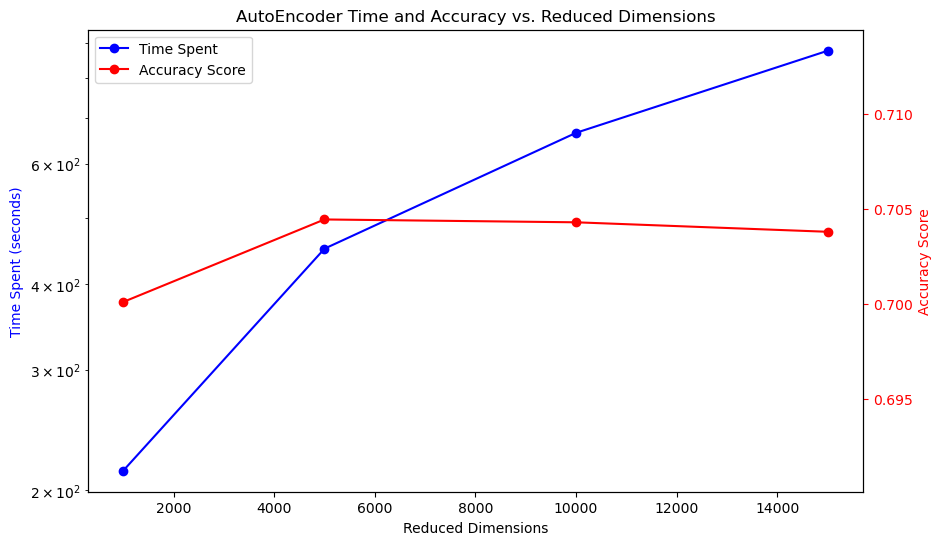

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd

df = pd.DataFrame({
    'Reduced Dimensions': reduced_dimensions,
    'Time Spent (seconds)': time_spent_list,
    'Accuracy Score': accuracy_score_list
})

plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax1.plot(reduced_dimensions, time_spent_list, marker='o', color='blue', label='Time Spent')
ax1.set_xlabel('Reduced Dimensions')
ax1.set_ylabel('Time Spent (seconds)', color='blue')
ax1.tick_params('y', colors='blue')

# 
ax2 = ax1.twinx()
ax2.plot(reduced_dimensions, accuracy_score_list, marker='o', color='red', label='Accuracy Score')
ax2.set_ylabel('Accuracy Score', color='red')
ax2.tick_params('y', colors='red')

ax1.set_yscale('log')  # 
ax2.set_ylim(min(accuracy_score_list) - 0.01, max(accuracy_score_list) + 0.01)  # 

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('AutoEncoder Time and Accuracy vs. Reduced Dimensions')

plt.show()


In [15]:
start_time = time.time()
rf_clf = RandomForestClassifier(random_state=2023)
scores_autoencoder = cross_val_score(rf_clf, X, np.array(full_df['label']).tolist(), cv=5, scoring='accuracy')
end_time = time.time()
elapsed_time = end_time - start_time
print(f'  Accuracy: {scores_autoencoder.mean()} - Time Spend: {elapsed_time}')

  Accuracy: 0.784 - Time Spend: 475.7763888835907


In [12]:
X_autoencoder.shape

(20000, 2500)

### Machine learning method
* This TF-IDF vector data is sparse matrix , so I try to perform data dimensionality reduction using Truncated SVD
* Combine with the different reduced dimensionalities to test the effect of dimensionalities on the performance of the classification baseline task

In [29]:
import pickle

# Specify reduced dimensionalities
reduced_dimensions = [1000, 5000, 10000, 15000]

best_svd_model = None
best_svd_accuracy = 0.0

best_autoencoder_model = None
best_autoencoder_accuracy = 0.0
time_spent_list = []
accuracy_score_list = []
for dimensionality in reduced_dimensions:
    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=dimensionality)
    X_svd = svd.fit_transform(X)

    # Train Random Forest on reduced data
    rf_clf = RandomForestClassifier(random_state=2023)
    start_time = time.time()
    scores_svd = cross_val_score(rf_clf, X_svd, np.array(full_df['label']).tolist(), cv=5, scoring='accuracy')
    end_time = time.time()
    elapsed_time = end_time - start_time
    time_spent_list.append(elapsed_time)
    accuracy_score_list.append(scores_autoencoder.mean())
    print(f'Truncated SVD - {dimensionality} Dimensions - Accuracy: {scores_svd.mean()} - Time Spend: {elapsed_time} (seconds)')

    if scores_svd.mean() > best_svd_accuracy:
        best_svd_accuracy = scores_svd.mean()
        best_svd_model = svd
        best_elapsed_time = elapsed_time
        best_model_dimensionality = dimensionality
        # Assuming best_model is your trained Pipeline
        with open('best_svd_model.pkl', 'wb') as file:
            pickle.dump(best_svd_model, file)


Truncated SVD - 1000 Dimensions - Accuracy: 0.73185 - Time Spend: 239.44569396972656
Truncated SVD - 5000 Dimensions - Accuracy: 0.704 - Time Spend: 695.5098552703857
Truncated SVD - 10000 Dimensions - Accuracy: 0.7021 - Time Spend: 1043.5355789661407
Truncated SVD - 15000 Dimensions - Accuracy: 0.702 - Time Spend: 1459.9656119346619


In [33]:
print(f"Time spend: {best_elapsed_time} (seconds)")
print(f'Best Autoencoder Accuracy: {best_svd_accuracy}')
print(f"Best Dimensions: {best_model_dimensionality}")

Time spend: 239.44569396972656
Best Autoencoder Accuracy: 0.73185
Best Dimensions: 1000


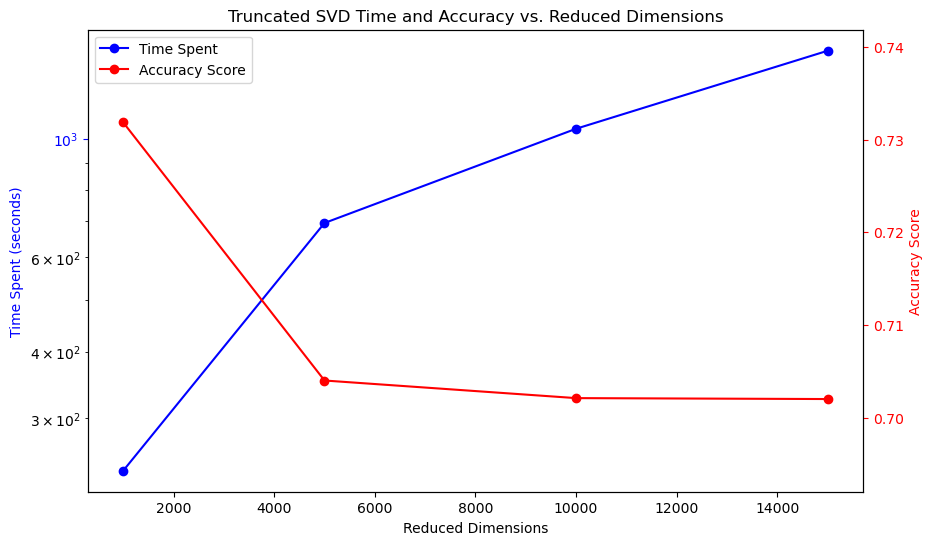

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'Reduced Dimensions': reduced_dimensions,
    'Time Spent (seconds)': time_spent_list,
    'Accuracy Score': accuracy_score_list
})

plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax1.plot(reduced_dimensions, time_spent_list, marker='o', color='blue', label='Time Spent')
ax1.set_xlabel('Reduced Dimensions')
ax1.set_ylabel('Time Spent (seconds)', color='blue')
ax1.tick_params('y', colors='blue')

# 
ax2 = ax1.twinx()
ax2.plot(reduced_dimensions, accuracy_score_list, marker='o', color='red', label='Accuracy Score')
ax2.set_ylabel('Accuracy Score', color='red')
ax2.tick_params('y', colors='red')

ax1.set_yscale('log')  # 
ax2.set_ylim(min(accuracy_score_list) - 0.01, max(accuracy_score_list) + 0.01)  # 

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Truncated SVD Time and Accuracy vs. Reduced Dimensions')

plt.show()
